# ML Water Explore

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import functions as fct
from vecstack import stacking
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.special import boxcox1p
from sklearn.decomposition import PCA
from pandas.api.types import CategoricalDtype
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.metrics import accuracy_score as metric_scorer
from scipy.stats import skew, boxcox_normmax, chi2_contingency
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, KBinsDiscretizer, PowerTransformer, LabelEncoder

from sklearn.feature_selection import RFECV

## Setting Key Values

In [26]:
SEED = 1
# Train X
#DATA_PATH = 'https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv'
DATA_PATH = 'TOTSET8.csv'
# Train y
#DATA_PATH2 = 'https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv'
# Test X
#DATA_PATH3 = 'https://s3.amazonaws.com/drivendata/data/7/public/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv'
# Submission Format
DATA_PATH4 = 'SubmissionFormat.csv'
TARGET_VARIABLE = 'status_group'
SPLITS = 5
ESTIMATORS = 50
MAX_ITER = 500
#For metric, import the required library as metric_scorer
METRIC = 'accuracy'

## Data Reading
Here we read the data, print its first rows and describe its contents

In [27]:
def read_data(input_path):
    return pd.read_csv(input_path, parse_dates=[1])

tot_data = read_data(DATA_PATH)
submission = read_data(DATA_PATH4)
#X_train = read_data(DATA_PATH)
#y_train = read_data(DATA_PATH2)
#X_test = read_data(DATA_PATH3)

tot_data.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


,id,funder,funder_cleaned,installer,installer_cleaned,4sameifone,3sameifone,2sameifone,1sameifone,amount_tsh,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,pr,tas
0,69572,Roman,roman church,Roman,roman church,True,True,True,True,6000.0,...,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,101.776,23.4426
1,8776,Grumeti,grumet,GRUMETI,grumet,True,True,True,False,0.0,...,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,157.643,23.7156
2,34310,Lottery Club,lottery club,World vision,world vision,False,False,False,False,25.0,...,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,157.643,23.7156
3,67743,Unicef,unicef,UNICEF,unicef,True,True,True,False,0.0,...,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,157.643,23.7156
4,19728,Action In A,action in a,Artisan,atisan,False,False,False,False,0.0,...,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,101.776,23.4426


We review the data types for each column

In [28]:
tot_data.dtypes

id                         int64
funder                    object
funder_cleaned            object
installer                 object
installer_cleaned         object
4sameifone                  bool
3sameifone                  bool
2sameifone                  bool
1sameifone                  bool
amount_tsh               float64
date_recorded             object
date                      object
Year                       int64
MY                        object
Month                      int64
gps_height                 int64
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_man

We check if there is any missing data

In [29]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data(tot_data).head(10)

,Total,Percent
scheme_name,35258,0.474855
status_group,14850,0.200000
scheme_management,4846,0.065266
installer_cleaned,4535,0.061077
installer,4532,0.061037
funder_cleaned,4504,0.060660
public_meeting,4155,0.055960
permit,3793,0.051084
subvillage,470,0.006330
tas,0,0.000000


We drop certainly unnecessary columns

In [30]:
def drop_columns(df, cols):
    df.drop(df[cols], axis=1, inplace = True)
    return df

tot_data = drop_columns(tot_data, ['recorded_by', '4sameifone', '3sameifone', '2sameifone', '1sameifone', 'date_recorded'])
submission = drop_columns(submission, ['status_group'])

In [91]:
def numerical_correlated(df, threshold=0.9):
    corr_matrix = np.absolute(df.select_dtypes(include=[np.number]).corr(method='spearman')).abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    return [column for column in upper.columns if any(abs(upper[column]) > threshold)], corr_matrix

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))

def categorical_correlated(df, threshold=0.9):
    columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0, len(columns)):
        for j in range(i, len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                cell = cramers_v(df[columns[i]], df[columns[j]])
                corr[columns[i]][columns[j]] = cell
                corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    upper = corr.where(
    np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    return [column for column in upper.columns if any(abs(upper[column]) > threshold)], corr

threshold = 0.9

def correlated(df, threshold = 0.9):
    return (categorical_correlated(df, threshold), numerical_correlated(df, threshold))

correlated_cols = correlated(data, threshold)

if(len(correlated_cols[0][0]) + len(correlated_cols[1][0]) > 0):
    print('The following columns are correlated with a threshold of ' + str(threshold) + ': ' + str(correlated_cols[0][0] + correlated_cols[1][0]))
else:
    print('No correlated columns for the  ' + str(threshold) + ' threshold')

The following columns are correlated with a threshold of 0.9: ['source_type_borehole', 'source_type_rainwater harvesting', 'source_type_river/lake', 'source_type_shallow well', 'source_type_spring', 'source_class_surface', 'pr', 'days_since_recorded']


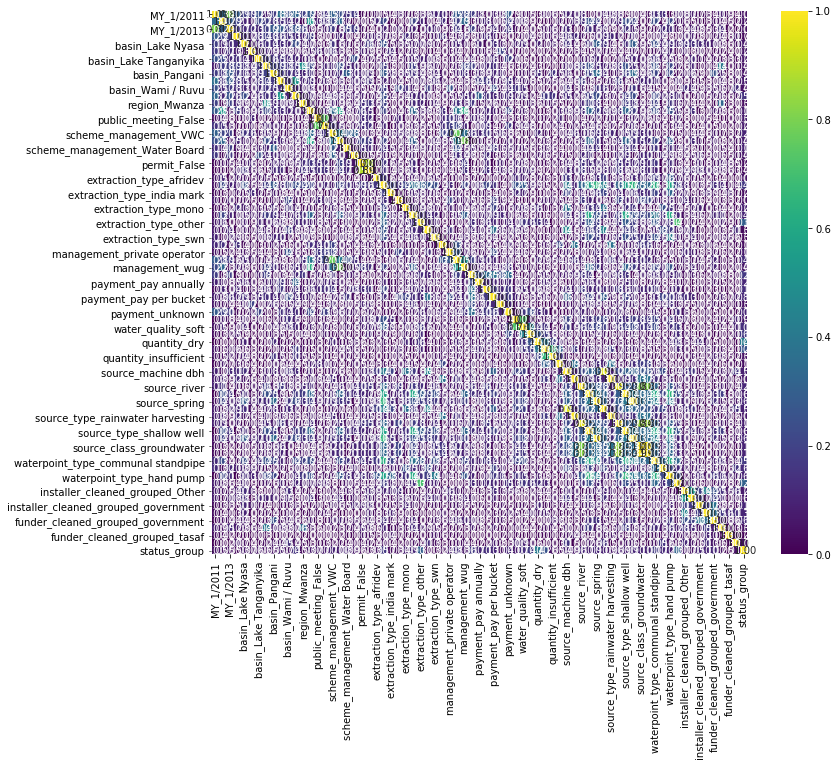

In [92]:
#categorical
plt.figure(figsize=(12,10))
sns.heatmap(correlated_cols[0][1],cbar=True,fmt =' .2f', annot=True, cmap='viridis')

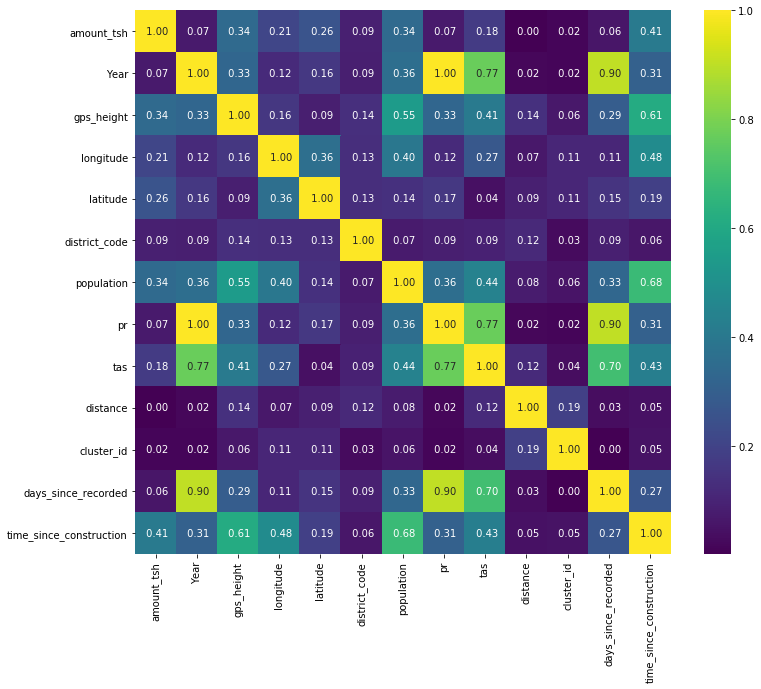

In [93]:
#numerical
plt.figure(figsize=(12,10))
sns.heatmap(correlated_cols[1][1],cbar=True,fmt =' .2f', annot=True, cmap='viridis')

## Data Preparation

### Converting Columns to their true type
Now fixing the data types of object columns that are actually categorical and of dates

In [31]:
def categoricals(df, exclude = None):
    categorical = df.select_dtypes(include=['category', object])
    excluded = [TARGET_VARIABLE]
    if exclude:
        for i in exclude:
            excluded.append(i)
    cols = [col for col in categorical.columns if col not in excluded]
    return df[cols]

In [32]:
def convert_to_category(df, cols):
    for i in cols:
        df[i] = df[i].astype('category')
    return df

#data = convert_to_category(data, data.iloc[:,13:15])

tot_data = pd.concat([
        tot_data.select_dtypes([], ['object']),
        tot_data.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex_axis(tot_data.columns, axis=1)

tot_data = convert_to_category(tot_data, ['date'])

tot_data['amount_tsh'] = pd.to_numeric(tot_data['amount_tsh'])

tot_data.dtypes

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  # This is added back by InteractiveShellApp.init_path()


id                          int64
funder                   category
funder_cleaned           category
installer                category
installer_cleaned        category
amount_tsh                float64
date                     category
Year                        int64
MY                       category
Month                       int64
gps_height                  int64
longitude                 float64
latitude                  float64
wpt_name                 category
num_private                 int64
basin                    category
subvillage               category
region                   category
region_code                 int64
district_code               int64
lga                      category
ward                     category
population                  int64
public_meeting           category
scheme_management        category
scheme_name              category
permit                   category
construction_year           int64
extraction_type          category
extraction_typ

## Scale and fix skewness

In [33]:
def numericals(df, exclude = None):
    numerical = df.select_dtypes(include=[np.number])
    excluded = [TARGET_VARIABLE]
    if exclude:
        for i in exclude:
            excluded.append(i)
    cols = [col for col in numerical.columns if col not in excluded]
    return df[cols]

Fill zeros in construction year with -1 and create dummy indicating previous zeros

In [34]:
tot_data['missing_construction_year'] = (tot_data['construction_year']==0)
tot_data['construction_year'][tot_data['construction_year'] == 0] = -1 #data['construction_year'].median()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [35]:
pt = PowerTransformer(method='yeo-johnson', standardize = True).fit(numericals(tot_data[~pd.isna(tot_data['status_group'])], ['id']))
tot_data[numericals(tot_data, ['id']).columns] = pt.transform(numericals(tot_data, ['id']))
tot_data.head()

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2778: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


,id,funder,funder_cleaned,installer,installer_cleaned,amount_tsh,date,Year,MY,Month,...,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,pr,tas,missing_construction_year
0,69572,Roman,roman church,Roman,roman church,1.743682,2011-01-14T00:03:00.000Z,-0.963404,1/2011,0.0,...,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,-0.832619,-0.471799,False
1,8776,Grumeti,grumet,GRUMETI,grumet,-0.647745,2013-01-06T00:03:00.000Z,1.129149,1/2013,0.0,...,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,1.202022,1.052600,False
2,34310,Lottery Club,lottery club,World vision,world vision,1.302939,2013-01-25T00:02:00.000Z,1.129149,1/2013,0.0,...,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,1.202022,1.052600,False
3,67743,Unicef,unicef,UNICEF,unicef,-0.647745,2013-01-28T00:01:00.000Z,1.129149,1/2013,0.0,...,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,1.202022,1.052600,False
4,19728,Action In A,action in a,Artisan,atisan,-0.647745,2011-01-13T00:07:00.000Z,-0.963404,1/2011,0.0,...,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,-0.832619,-0.471799,True


In [36]:
#data = X_train.merge(y_train, on = ['id'])
data = tot_data[~pd.isna(tot_data['status_group'])].copy()

test = tot_data[pd.isna(tot_data['status_group'])].copy()

data.head()

,id,funder,funder_cleaned,installer,installer_cleaned,amount_tsh,date,Year,MY,Month,...,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,pr,tas,missing_construction_year
0,69572,Roman,roman church,Roman,roman church,1.743682,2011-01-14T00:03:00.000Z,-0.963404,1/2011,0.0,...,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,-0.832619,-0.471799,False
1,8776,Grumeti,grumet,GRUMETI,grumet,-0.647745,2013-01-06T00:03:00.000Z,1.129149,1/2013,0.0,...,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,1.202022,1.052600,False
2,34310,Lottery Club,lottery club,World vision,world vision,1.302939,2013-01-25T00:02:00.000Z,1.129149,1/2013,0.0,...,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,1.202022,1.052600,False
3,67743,Unicef,unicef,UNICEF,unicef,-0.647745,2013-01-28T00:01:00.000Z,1.129149,1/2013,0.0,...,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,1.202022,1.052600,False
4,19728,Action In A,action in a,Artisan,atisan,-0.647745,2011-01-13T00:07:00.000Z,-0.963404,1/2011,0.0,...,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,-0.832619,-0.471799,True


## Plotting the target variable

In [37]:
data['status_group'].unique()

[functional, non functional, functional needs repair]
Categories (3, object): [functional, non functional, functional needs repair]

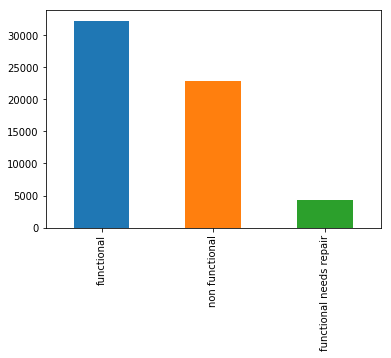

In [38]:
data['status_group'].value_counts().plot(kind='bar')

## Explore distribution of target variable for missing values

In [39]:
vars_with_nan = ['scheme_name', 'scheme_management', 'installer', 'funder', 
                    'public_meeting', 'public_meeting', 'subvillage']

missing_vals = data[vars_with_nan]

In [40]:
mv = pd.DataFrame()
    
mv['overall'] = [len(data[data['status_group'] == 'functional'])/len(data),
                len(data[data['status_group'] == 'non functional'])/len(data),
                len(data[data['status_group'] == 'functional needs repair'])/len(data)]

for col in ['scheme_name', 'scheme_management', 'installer', 'funder', 
                    'public_meeting', 'public_meeting', 'subvillage']:
    mv[col] = [(data[data['status_group'] == 'functional'][col].isnull().sum())/(data[col].isnull().sum()),
              (data[data['status_group'] == 'non functional'][col].isnull().sum())/(data[col].isnull().sum()),
              (data[data['status_group'] == 'functional needs repair'][col].isnull().sum())/(data[col].isnull().sum())]

mv = mv.rename({0: 'functional', 1: 'non functional', 2: 'functional needs repair'})
mv

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


,overall,scheme_name,scheme_management,installer,funder,public_meeting,subvillage
functional,0.543081,0.514379,0.483105,0.547196,NaN,0.503299,0.552561
non functional,0.384242,0.414471,0.459376,0.332421,NaN,0.449910,0.444744
functional needs repair,0.072677,0.071150,0.057519,0.120383,NaN,0.046791,0.002695


Missing values appear to contain information regarding whether a pump is funcional

Create separate dataframe without nans for EDA

In [41]:
data_complete = data[data.isnull().any(axis=1)==False]
data_incomplete = data[data.isnull().any(axis=1)]
data.describe()

,id,amount_tsh,Year,Month,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,pr,tas
count,59400.000000,5.940000e+04,5.940000e+04,59400.0,5.940000e+04,5.940000e+04,5.940000e+04,5.940000e+04,5.940000e+04,5.940000e+04,5.940000e+04,5.940000e+04,5.940000e+04,5.940000e+04
mean,37115.131768,1.407034e-15,-2.417673e-15,0.0,2.032886e-16,-1.119172e-15,-2.957782e-16,-8.759576e-16,7.339415e-16,-1.305858e-16,-8.556380e-17,-1.497754e-16,-8.159793e-12,-9.753403e-16
std,21453.128371,1.000008e+00,1.000008e+00,0.0,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,0.000000,-6.477450e-01,-9.281468e+00,0.0,-1.488847e+01,-3.470305e+00,-1.846275e+00,-1.136161e-01,-2.170836e+00,-3.892854e+00,-1.077493e+00,-1.366858e+00,-8.326193e-01,-1.914349e+00
25%,18519.750000,-6.477450e-01,-9.634038e-01,0.0,-9.441700e-01,-5.487382e-01,-9.594517e-01,-1.136161e-01,-7.877979e-01,-5.055198e-01,-1.077493e+00,-1.366858e+00,-8.326193e-01,-4.717990e-01
50%,37061.500000,-6.477450e-01,7.093573e-02,0.0,8.520592e-03,-2.678733e-02,1.598144e-01,-1.136161e-01,1.630720e-01,4.763233e-02,2.341516e-01,7.283197e-01,-8.297479e-01,-4.717990e-01
75%,55656.500000,1.249552e+00,1.129149e+00,0.0,9.229554e-01,7.098709e-01,7.685124e-01,-1.136161e-01,5.578206e-01,6.703418e-01,9.728158e-01,7.337835e-01,1.202022e+00,1.052600e+00
max,74247.000000,1.770341e+00,1.129149e+00,0.0,1.803178e+00,1.908176e+00,2.268259e+00,8.801570e+00,2.585770e+00,2.349911e+00,2.408334e+00,7.365019e-01,1.734706e+00,9.280136e+00


In [42]:
#data_filled = data

#for var in vars_with_nan:
#    data_filled = data_filled[var].cat.add_categories(['missing_value'])
#    data_filled = data_filled.fillna('missing_value')

#data_filled.head()

### Some plots

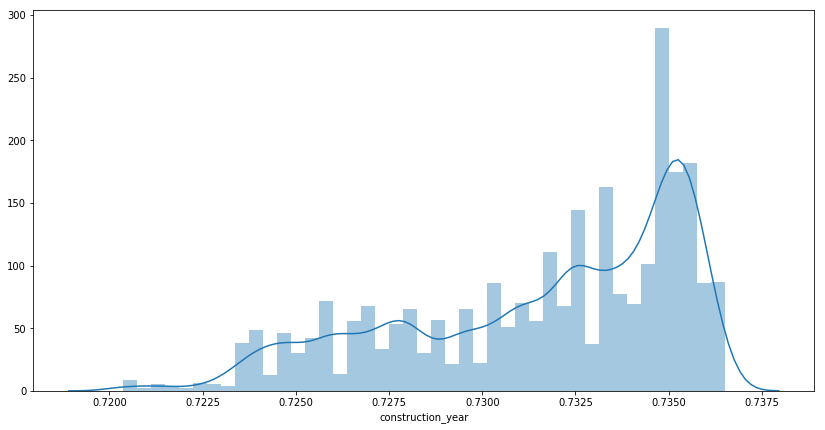

In [43]:
plt.figure(figsize=(14,7))
sns.distplot(data['construction_year'][data['construction_year']>0])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


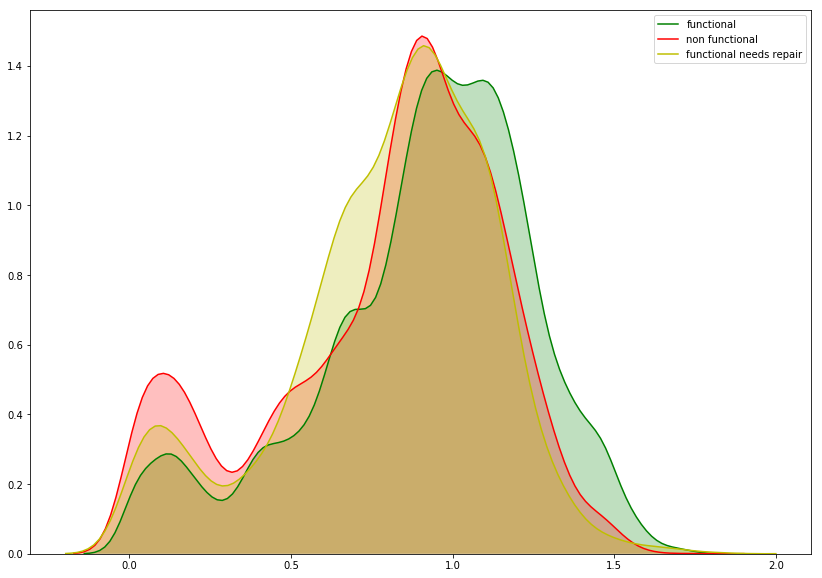

In [44]:
plt.figure(figsize=(14,10))

p1=sns.kdeplot(data[['gps_height','status_group']][data.status_group == 'functional']\
               [data.gps_height > 0].gps_height, shade=True, color="g",label='functional')
p1=sns.kdeplot(data[['gps_height','status_group']][data.status_group == 'non functional']\
               [data.gps_height > 0].gps_height, shade=True, color="r",label='non functional')
p1=sns.kdeplot(data[['gps_height','status_group']][data.status_group == 'functional needs repair']\
               [data.gps_height > 0].gps_height, shade=True, color="y",label='functional needs repair')

#from this, we can look into doing an LDA

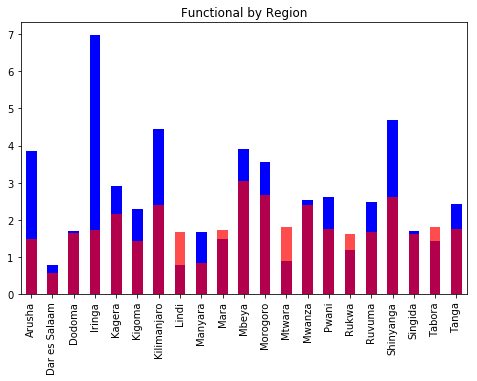

In [45]:
plt.figure(figsize=(8,5))
((data[data.status_group=='functional'].region.value_counts().sort_index()/len(data.status_group))*100).plot(kind='bar',color='b')
((data[data.status_group=='non functional'].region.value_counts().sort_index()/len(data.status_group))*100).plot(kind='bar',color='r',alpha=0.7, title = 'Functional by Region')

### One Hot Encode vs Label Encode

In [46]:
def one_hot_encode(df, cols):
    initialColumns = set(df)
    
    for i in cols:
        dummies = pd.get_dummies(df[i], prefix=i, drop_first = False)
        df = pd.concat([df, dummies], axis = 1)
        df = df.drop(i, axis = 1)
    
    df = convert_to_category(df, set(df) - initialColumns)
    return df

# encoded = one_hot_encode(tot_data, categoricals(tot_data))

encoded = tot_data.copy()
encoded[categoricals(tot_data, ['status_group']).columns] = categoricals(tot_data, ['status_group']).astype(str).apply(LabelEncoder().fit_transform)

data = encoded[~pd.isna(encoded['status_group'])].copy()

test = encoded[pd.isna(encoded['status_group'])].copy()

encoded.head()

,id,funder,funder_cleaned,installer,installer_cleaned,amount_tsh,date,Year,MY,Month,...,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,pr,tas,missing_construction_year
0,69572,1548,1476,1706,1379,1.743682,104,-0.963404,3,0.0,...,1,8,6,0,1,1,functional,-0.832619,-0.471799,False
1,8776,522,499,610,507,-0.647745,297,1.129149,5,0.0,...,2,5,3,1,1,1,functional,1.202022,1.052600,False
2,34310,924,877,2296,1832,1.302939,353,1.129149,5,0.0,...,1,0,1,1,2,1,functional,1.202022,1.052600,False
3,67743,1961,1858,2078,1704,-0.647745,361,1.129149,5,0.0,...,0,3,0,0,2,1,non functional,1.202022,1.052600,False
4,19728,20,18,133,103,-0.647745,100,-0.963404,3,0.0,...,3,5,3,1,1,1,functional,-0.832619,-0.471799,True


## Baseline

In [47]:
baseline_score, baseline_scores, baseline_model = fct.cv_evaluate(data, splits = 3)

print('Best baseline score: \n' + str(baseline_score) + '\n All scores: ' + str(baseline_scores))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Best baseline score: 
0.543658810325477
 All scores: [0.5439962  0.54848485 0.54572464]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


from sklearn.metrics import roc_auc_score, roc_curve, classification_report

def calculate_roc(df, model):
    X = df.loc[:, df.columns != TARGET_VARIABLE]
    y = df.loc[:, TARGET_VARIABLE]
    model.fit(X,y)
    y_pred = model.predict(X)
    logit_roc_auc = roc_auc_score(y, y_pred)
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
    plot_roc(fpr, tpr, logit_roc_auc)
    return y, y_pred

matrix = calculate_roc(data, model)

## Feature Engineering

### Add variables

In [48]:
xtra = tot_data.copy()

**Put together some levels**

In [49]:
cleanup = {"extraction_type":{"cemo": 'other motorpump', "climax": 'other motorpump',
                             'other - mkulima/shinyanga': 'walimi', 'other - play pump': 'walimi',
                             'other - swn 81': 'swn', 'swn 80': 'swn',
                             'india mark ii': 'india mark', 'india mark iii': 'india mark',
                             'other - swn 81': 'swn', 'swn 80': 'swn'}}

In [50]:
xtra.replace(cleanup, inplace = True)

**Remove underrepresented levels**

In [51]:
def drop_underrepresented(df, columns, threshold):
    for col in columns:
        freq = pd.value_counts(df[col])
        mask = (freq/freq.sum()).lt(threshold)
        colname = col + '_grouped'
        df[colname] = np.where(df[col].isin(freq[mask].index),'Other',df[col])
    return df

In [52]:
xtra = drop_underrepresented(xtra, ['installer_cleaned', 'funder_cleaned'], 0.01)

**Create geocraphical variables**

Distance from (0,0)

In [53]:
from geopy.distance import great_circle

xtra['distance'] = xtra.apply(
    lambda x: great_circle(
        (x['latitude'], x['longitude']),
        (0, 0)
    ).miles,
    axis=1)

Geographical clusters

In [54]:
X_loc=xtra.loc[:,['latitude','longitude']]

id_n=300
kmeans = KMeans(n_clusters=id_n, random_state=0).fit(X_loc)
xtra['cluster_id'] = kmeans.labels_

**Create Clusters**

**Create Date variables**

In [55]:
xtra['date'] = pd.to_datetime(xtra['date'], utc = True)

In [56]:
xtra['days_since_recorded'] = pd.to_datetime('2014-01-01', utc = True) - xtra['date']
xtra['days_since_recorded'] = pd.to_numeric(xtra['days_since_recorded'])/100000000

xtra['time_since_construction'] = 2015 - xtra['construction_year']

**Create indicator variables**

In [57]:
xtra['amount_tsh_zero'] = ((xtra['amount_tsh'] + 1) == True).astype(int)

xtra['missing_scheme_name'] = (xtra['scheme_name'].isnull() == True)

xtra['missing_installer'] = (xtra['installer_cleaned'].isnull() == True)


xtra['missing_funder'] = (xtra['funder_cleaned'].isnull() == True)

xtra['missing_public_meeting'] = (xtra['public_meeting'].isnull() == True)

xtra['missing_subvillage'] = (xtra['subvillage'].isnull() == True)

In [58]:
xtra.head()

,id,funder,funder_cleaned,installer,installer_cleaned,amount_tsh,date,Year,MY,Month,...,distance,cluster_id,days_since_recorded,time_since_construction,amount_tsh_zero,missing_scheme_name,missing_installer,missing_funder,missing_public_meeting,missing_subvillage
0,69572,Roman,roman church,Roman,roman church,1.743682,2011-01-14 00:03:00+00:00,-0.963404,1/2011,0.0,...,92.870653,161,935710200.0,2014.267731,0,False,False,False,False,False
1,8776,Grumeti,grumet,GRUMETI,grumet,-0.647745,2013-01-06 00:03:00+00:00,1.129149,1/2013,0.0,...,85.566930,230,311038200.0,2014.264403,0,True,False,False,True,False
2,34310,Lottery Club,lottery club,World vision,world vision,1.302939,2013-01-25 00:02:00+00:00,1.129149,1/2013,0.0,...,68.917971,39,294622800.0,2014.264705,0,False,False,False,False,False
3,67743,Unicef,unicef,UNICEF,unicef,-0.647745,2013-01-28 00:01:00+00:00,1.129149,1/2013,0.0,...,143.542134,151,292031400.0,2014.271680,0,True,False,False,False,False
4,19728,Action In A,action in a,Artisan,atisan,-0.647745,2011-01-13 00:07:00+00:00,-0.963404,1/2011,0.0,...,119.232628,140,936571800.0,2016.366858,0,True,False,False,False,False


### Encode categorical variables to continuous

In [59]:
xtra_test = xtra[pd.isna(xtra['status_group'])].copy()
xtra_train = xtra[~pd.isna(xtra['status_group'])].copy()

In [60]:
xtra_test.shape

(14850, 60)

In [61]:
def encode_to_continuous(df, df_test, columns, target, targetvalue):
    for col in columns:
        colname = col + '_success'
        
        df[colname] = np.where(df[target].isin([targetvalue]),1 ,0).copy()
        df_grouped = df.groupby([col])[colname].sum()
        df_counter = df.groupby([col]).agg('count')[colname]
        
        success = pd.DataFrame(df_grouped/df_counter)
        success[col] = success.index
        df.drop([colname], inplace = True, axis = 1)
        
        df = df.merge(success, on = col)
        df_test = df_test.merge(success, on = col)
        df_test[colname] = df_test[colname].fillna(df_test[colname].mean())
                
    return df, df_test

In [62]:
#xtra_train, xtra_test = encode_to_continuous(xtra_train, xtra_test, ['ward', 'lga'], 'status_group', 'functional')

In [63]:
xtra_train.head()

,id,funder,funder_cleaned,installer,installer_cleaned,amount_tsh,date,Year,MY,Month,...,distance,cluster_id,days_since_recorded,time_since_construction,amount_tsh_zero,missing_scheme_name,missing_installer,missing_funder,missing_public_meeting,missing_subvillage
0,69572,Roman,roman church,Roman,roman church,1.743682,2011-01-14 00:03:00+00:00,-0.963404,1/2011,0.0,...,92.870653,161,935710200.0,2014.267731,0,False,False,False,False,False
1,8776,Grumeti,grumet,GRUMETI,grumet,-0.647745,2013-01-06 00:03:00+00:00,1.129149,1/2013,0.0,...,85.566930,230,311038200.0,2014.264403,0,True,False,False,True,False
2,34310,Lottery Club,lottery club,World vision,world vision,1.302939,2013-01-25 00:02:00+00:00,1.129149,1/2013,0.0,...,68.917971,39,294622800.0,2014.264705,0,False,False,False,False,False
3,67743,Unicef,unicef,UNICEF,unicef,-0.647745,2013-01-28 00:01:00+00:00,1.129149,1/2013,0.0,...,143.542134,151,292031400.0,2014.271680,0,True,False,False,False,False
4,19728,Action In A,action in a,Artisan,atisan,-0.647745,2011-01-13 00:07:00+00:00,-0.963404,1/2011,0.0,...,119.232628,140,936571800.0,2016.366858,0,True,False,False,False,False


In [64]:
pd.options.display.max_rows = 200

**Selected columns**

In [65]:
selected_cols = ['amount_tsh', 'Year', 'MY', 'gps_height', 'longitude', 'latitude', 'num_private', 'basin', 'region',
                 'district_code', 'population', 'public_meeting', 'scheme_management', 'permit',
                 'extraction_type', 'management', 'payment', 'water_quality', 'quantity', 'source', 'source_type',
                 'source_class', 'waterpoint_type', 'pr', 'tas', 'missing_construction_year',
                 'installer_cleaned_grouped', 'funder_cleaned_grouped', 'distance', 'cluster_id', 'days_since_recorded',
                 'time_since_construction', 'amount_tsh_zero', 'missing_scheme_name', 'missing_installer', 'missing_funder',
                 'missing_public_meeting', 'missing_subvillage', 'status_group']
not_selected_cols = ['funder', 'funder_cleaned', 'installer', 'installer_cleaned', 'wpt_name', 'subvillage',
                     'scheme_name', 'extraction_type_group', 'extraction_type_class', 'management_group', 
                     'payment_type', 'quality_group', 'quantity_group', 'lga', 'ward', 'waterpoint_type_group']

, 'subvillage_success', 'lga_success', 'wpt_name_success',
                 'ward_success', 'scheme_name_success'

In [66]:
xtra_train_selected = xtra_train[selected_cols].copy()
xtra_test_selected = xtra_test[selected_cols].copy()

**Onehot Encode**

In [67]:
xtra_train_dummyfied = one_hot_encode(xtra_train_selected, categoricals(xtra_train_selected))
xtra_test_dummyfied = one_hot_encode(xtra_test_selected, categoricals(xtra_test_selected))

In [68]:
xtra_train_dummyfied.head()

,amount_tsh,Year,gps_height,longitude,latitude,num_private,district_code,population,pr,tas,...,funder_cleaned_grouped_norad,funder_cleaned_grouped_private individual,funder_cleaned_grouped_roman church,funder_cleaned_grouped_rwssp,funder_cleaned_grouped_tasaf,funder_cleaned_grouped_tcrs,funder_cleaned_grouped_unicef,funder_cleaned_grouped_wateraid,funder_cleaned_grouped_world bank,funder_cleaned_grouped_world vision
0,1.743682,-0.963404,0.974640,-0.017877,-1.344013,-0.113616,0.670342,0.746320,-0.832619,-0.471799,...,0,0,1,0,0,0,0,0,0,0
1,-0.647745,1.129149,0.981122,-0.090077,1.235144,-0.113616,-0.505520,1.058946,1.202022,1.052600,...,0,0,0,0,0,0,0,0,0,0
2,1.302939,1.129149,0.380148,0.808415,0.584308,-0.113616,0.410603,1.022130,1.202022,1.052600,...,0,0,0,0,0,0,0,0,0,0
3,-0.647745,1.129149,-0.149872,1.179788,-1.710133,-0.113616,2.287415,0.529916,1.202022,1.052600,...,0,0,0,0,0,0,1,0,0,0
4,-0.647745,-0.963404,-0.944170,-1.047628,1.371361,-0.113616,-1.484429,-1.077493,-0.832619,-0.471799,...,0,0,0,0,0,0,0,0,0,0


**Select relevant variables**

In [69]:
trans = RFE(RandomForestClassifier(n_estimators = 10, random_state = 1))

y_train_rfe = xtra_train_dummyfied['status_group'].copy()

X_train_rfe = xtra_train_dummyfied.loc[:, xtra_train_dummyfied.columns != TARGET_VARIABLE]

X_test_rfe = xtra_test_dummyfied.loc[:, xtra_test_dummyfied.columns != TARGET_VARIABLE]

trans.fit(X_train_rfe, y_train_rfe)
#data_rfe = trans.transform(X_train_rfe)
#test_rfe = trans.transform(X_test_rfe)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
  n_features_to_select=None, step=1, verbose=0)

In [70]:
xtra.shape

(74250, 60)

In [71]:
len(trans.support_)

181

In [72]:
prev_data = data.copy()
prev_test = test.copy()

In [73]:
prev_test.shape

(14850, 48)

In [99]:
data = X_train_rfe.iloc[:,trans.support_].copy()
test = X_test_rfe.iloc[:,trans.support_].copy()

In [100]:
data['status_group'] = prev_data['status_group']

In [76]:
data.dtypes

amount_tsh                                      float64
Year                                            float64
gps_height                                      float64
longitude                                       float64
latitude                                        float64
district_code                                   float64
population                                      float64
pr                                              float64
tas                                             float64
missing_construction_year                          bool
distance                                        float64
cluster_id                                        int32
days_since_recorded                             float64
time_since_construction                         float64
missing_scheme_name                                bool
missing_installer                                  bool
missing_funder                                     bool
missing_public_meeting                          

In [77]:
#rfc = RandomForestClassifier(n_estimators = 50, random_state = 1)

#df_temp1 = X_train_rfe.iloc[:,trans.support_]
#y_loop = prev_data['status_group']

In [78]:
#scores_loop = cross_val_score(rfc, df_temp1, y_loop, cv=5)

## Randomized GridSearch

Random Forest

In [116]:
grid_rf = {
    'max_depth': [10, 20, 90],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [5, 10, 20],
    'max_leaf_nodes': [10, 20, 50],
    'n_estimators': [10, 100, 500]
}

rfc_grid = RandomForestClassifier(random_state = SEED)

grid_holdout_score, grid_scores, grid_model = fct.cv_evaluate(data, model = rfc_grid, grid = grid_rf)
score = {'Model': 'RandomForest', 'Function': 'cross_evaluate','CV Score': '{:.3f} +/- {:.02}'.format(np.mean(grid_scores[grid_scores > 0.0]),np.std(grid_scores[grid_scores > 0.0])), 'Holdout Score': "{0:.3f}".format(grid_holdout_score), 'Difference': 0, 'Outcome': 'Final Cross Validation'}
#all_scores = all_scores.append(score, ignore_index=True)

In [122]:
grid_rf2 = {
    'max_depth': [10, 20, 90, None],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5, 20],
    'max_leaf_nodes': [10, 20, 50, None],
    'n_estimators': [10, 50, 100, 500, 1000]
}

rfc_grid2 = RandomForestClassifier(random_state = SEED)

grid_holdout_score2, grid_scores2, grid_model2 = fct.cv_evaluate(data, model = rfc_grid2, grid = grid_rf2)
score2 = {'Model': 'RandomForest', 'Function': 'cross_evaluate','CV Score': '{:.3f} +/- {:.02}'.format(np.mean(grid_scores2[grid_scores2 > 0.0]),np.std(grid_scores2[grid_scores2 > 0.0])), 'Holdout Score': "{0:.3f}".format(grid_holdout_score2), 'Difference': 0, 'Outcome': 'Final Cross Validation'}
#all_scores = all_scores.append(score, ignore_index=True)

In [124]:
score2 = {'Model': 'RandomForest', 'Function': 'cross_evaluate','CV Score': '{:.3f} +/- {:.02}'.format(np.mean(grid_scores2[grid_scores2 > 0.0]),np.std(grid_scores2[grid_scores2 > 0.0])), 'Holdout Score': "{0:.3f}".format(grid_holdout_score2), 'Difference': 0, 'Outcome': 'Final Cross Validation'}

In [125]:
score2

{'Model': 'RandomForest',
 'Function': 'cross_evaluate',
 'CV Score': '0.726 +/- 0.021',
 'Holdout Score': '0.811',
 'Difference': 0,
 'Outcome': 'Final Cross Validation'}

In [129]:
grid_model2.best_params_

{'n_estimators': 10,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_leaf_nodes': None,
 'max_features': 'auto',
 'max_depth': None}

Logistic Regression

In [138]:
grid_gbt = {
    'learning_rate': [0.05, 0.1, 0.3],
    'n_estimators': [50, 100, 500],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [2, 5, 20],
    'max_depth': [2, 3, 5]
}

gbt_grid = GradientBoostingClassifier(random_state = SEED)

grid_holdout_score3, grid_scores3, grid_model3 = fct.cv_evaluate(data, model = gbt_grid, grid = grid_gbt)
score3 = {'Model': 'RandomForest', 'Function': 'cross_evaluate','CV Score': '{:.3f} +/- {:.02}'.format(np.mean(grid_scores3[grid_scores3 > 0.0]),np.std(grid_scores3[grid_scores3 > 0.0])), 'Holdout Score': "{0:.3f}".format(grid_holdout_score3), 'Difference': 0, 'Outcome': 'Final Cross Validation'}
#all_scores = all_scores.append(score, ignore_index=True)

In [140]:
score3

{'Model': 'RandomForest',
 'Function': 'cross_evaluate',
 'CV Score': '0.757 +/- 0.026',
 'Holdout Score': '0.800',
 'Difference': 0,
 'Outcome': 'Final Cross Validation'}

In [141]:
grid_model3.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 5,
 'learning_rate': 0.3}

## Running the pipeline

In [79]:
MAX_ITER = 1300

In [146]:
models = [
#     {'name':'logistic_regression', 'model': LogisticRegression(multi_class = 'ovr', solver = 'lbfgs', max_iter = MAX_ITER)},
    {'name':'random_forest', 'model': RandomForestClassifier(n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_leaf_nodes=None, max_features= 'auto', max_depth=None, random_state = SEED)},
    {'name':'gradient_boosting', 'model': GradientBoostingClassifier(n_estimators = 100, min_samples_split=2, min_samples_leaf=2, max_depth=5,learning_rate=0.3, random_state = SEED)}
]

transformers = [
#     {'name':'rfe', 'transformer': RFE(LogisticRegression(multi_class = 'ovr', solver = 'lbfgs', max_iter = MAX_ITER))},
#     {'name':'rfe', 'transformer': RFE(RandomForestRegressor(random_state = SEED))},
#     {'name':'feature_selection', 'transformer': SelectFromModel(LogisticRegression(multi_class = 'ovr', solver = 'lbfgs', max_iter = MAX_ITER))},
#     {'name':'feature_selection', 'transformer': SelectFromModel(RandomForestRegressor(random_state = SEED))},
#     {'name':'binning', 'transformer': KBinsDiscretizer(n_bins=5, encode='onehot')},
#     {'name':'binning', 'transformer': KBinsDiscretizer(n_bins=6, encode='onehot')},
#    {'name':'polynomial', 'transformer': PolynomialFeatures(degree=2, include_bias=False)},
#     {'name':'polynomial', 'transformer': PolynomialFeatures(degree=3, include_bias=False)},
#     {'name':'pca', 'transformer': PCA(.90)},
#     {'name':'pca', 'transformer': PCA(.95)},
#     {'name':'gp', 'transformer': SymbolicTransformer(population_size=750, metric='spearman', function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min', 'sin', 'cos', 'tan'],parsimony_coefficient=0.0005,max_samples=0.9,random_state=SEED)}
]

pipelines, all_scores = fct.feature_engineering_pipeline(data, models, transformers, SPLITS)

In [147]:
all_scores

,Model,Function,CV Score,Holdout Score,Difference,Outcome
0,random_forest,base_score,0.81 +/- 0.0034,0.814927,0,Base random_forest
1,gradient_boosting,base_score,0.80 +/- 0.004,0.799888,0,Base gradient_boosting


In [148]:
models = [
    OneVsRestClassifier(pipelines[0]['pipeline']),
    pipelines[0]['pipeline'],
    pipelines[1]['pipeline']
]


X_train = data.loc[:, data.columns != TARGET_VARIABLE]
y_train = data['status_group'].copy()
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)

X_test = test.loc[:, test.columns != TARGET_VARIABLE]


S_train, S_test = stacking(
    models,                   
    X_train,
    y_train,
    X_test,  
    regression=False, 
    mode='oof_pred_bag', 
    needs_proba=False,
    save_dir=None, 
    metric=METRIC, 
    n_folds=4, 
    stratified=True,
    shuffle=True,  
    random_state=SEED
)

final_model = pipelines[0]['model']
final_model.fit(S_train, y_train)
X_test[TARGET_VARIABLE] = le.inverse_transform(final_model.predict(S_test))

X_test['id'] = prev_test['id'].copy()

submission_6 = submission.copy()
submission_6 = submission_6.merge(X_test, on = 'id', how = 'left', suffixes = ('',''))

In [160]:
X_train = data.loc[:, data.columns != TARGET_VARIABLE].copy()
y_train = data['status_group'].copy()

#y_train = le.transform(y_train)

X_test = test.loc[:, test.columns != TARGET_VARIABLE].copy()

In [161]:
rfc = RandomForestClassifier(n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_leaf_nodes=None, max_features= 'auto', max_depth=None, random_state = 21)
rfc.fit(X_train, y_train)

X_test[TARGET_VARIABLE] = rfc.predict(X_test)

X_test['id'] = prev_test['id'].copy()

submission_only_rfc_tuned = submission.copy()
submission_only_rfc_tuned = submission_only_rfc_tuned.merge(X_test, on = 'id', how = 'left', suffixes = ('',''))

In [162]:
submission_only_rfc_tuned[['id', 'status_group']].to_csv('predictions_only_rfc_tuned21.csv', sep=',', index = False)